In [1]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook
import re
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import load_iris
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
# Set random seed
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [3]:
# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Python Version: {platform.python_version()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Linux
CUDA: True
Python Version: 3.8.5
torch Version: 1.7.1
torchvision Version: 0.8.2


In [4]:
IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG", ".png",
    ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]
device = torch.device("cuda")

In [5]:
df = pd.read_csv("/opt/ml/input/data/train/train.csv")
df.head(5)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


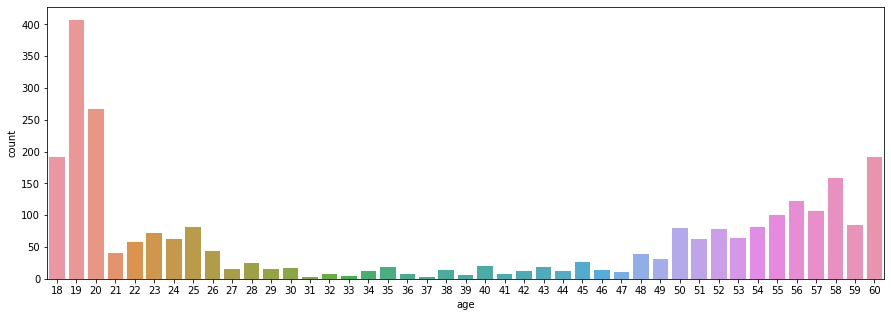

In [14]:
import pandas as pd
import seaborn as sns

x = df['id']
y = df['age']

plt.figure(figsize=(15, 5))
sns.countplot(y, data=df)
plt.show()

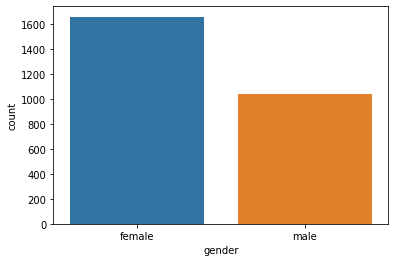

<Figure size 1080x360 with 0 Axes>

In [25]:
sns.countplot(df['gender'], data=df)
plt.show()

In [68]:
is_male = df['gender'] == 'male'
is_female = df['gender'] == 'female'
ageunder_30 = df['age'] < 30
ageover_60 = df['age'] >= 60

ageover_30 = df['age'] >= 30
ageunder_60 = df['age'] < 60


# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다. (AND)
male_60 = df[is_male & ageover_60]
female_60 = df[is_female & ageover_60]

male_under_30 = df[is_male & ageunder_30]
female_under_30 = df[is_female & ageunder_30]

male_in_30_60 = df[is_male & ageover_30 & ageunder_60]
female_in_30_60 = df[is_female & ageover_30 & ageunder_60]


# 결과를 출력합니다.

print("30미만 남자: ", len(male_under_30))
print("30미만 여자: ", len(female_under_30))
print("\n")

print("30이상이고 60미만 남자: ", len(male_in_30_60))
print("30이상이고 60미만 여자: ", len(female_in_30_60))
print("\n")

print("60이상 남자: ", len(male_60))
print("60이상 여자: ", len(female_60))

30미만 남자:  549
30미만 여자:  732


30이상이고 60미만 남자:  410
30이상이고 60미만 여자:  817


60이상 남자:  83
60이상 여자:  109


In [94]:
x = [male_under_30, female_under_30, male_in_30_60, female_in_30_60, male_60, female_60]
y = df['age']

In [97]:
train_info = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_info.head(5)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [230]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'

#train_dir_names = [f for f in glob(train_dir + "/images/*")]

In [257]:
#train data와 test data 추출

train_file_name = [f for f in glob(train_dir + "/images/*/*")]
train_file_names = []

for i in range(len(train_file_name)):
    train_file_names.append("/".join(train_file_name[i].split('/')[7:9]))

# id와 맞춰주려고 sorted
sorted(train_file_names)
test_file_names = [f for f in glob(test_dir + '/images/*')]

In [379]:
df = pd.DataFrame(train_file_names, columns=['file'])
df.head(5)

,file
0,000001_female_Asian_45/incorrect_mask.jpg
1,000001_female_Asian_45/mask1.jpg
2,000001_female_Asian_45/mask2.jpg
3,000001_female_Asian_45/mask3.jpg
4,000001_female_Asian_45/mask4.jpg


In [380]:
for i in df.index:
    df.loc[i, 'gender'] = train_file_names[i].split('/')[0].split('_')[1]
    df.loc[i, 'age'] = train_file_names[i].split('/')[0].split('_')[3]
    df.loc[i, 'mask'] = train_file_names[i].split('/')[1].split('.')[0]

In [381]:
df['class'] = 0
df.head(10)

,file,gender,age,mask,class
0,000001_female_Asian_45/incorrect_mask.jpg,female,45,incorrect_mask,0
1,000001_female_Asian_45/mask1.jpg,female,45,mask1,0
2,000001_female_Asian_45/mask2.jpg,female,45,mask2,0
3,000001_female_Asian_45/mask3.jpg,female,45,mask3,0
4,000001_female_Asian_45/mask4.jpg,female,45,mask4,0
5,000001_female_Asian_45/mask5.jpg,female,45,mask5,0
6,000001_female_Asian_45/normal.jpg,female,45,normal,0
7,000002_female_Asian_52/incorrect_mask.jpg,female,52,incorrect_mask,0
8,000002_female_Asian_52/mask1.jpg,female,52,mask1,0
9,000002_female_Asian_52/mask2.jpg,female,52,mask2,0


In [382]:
df['age'] = df['age'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    18900 non-null  object
 1   gender  18900 non-null  object
 2   age     18900 non-null  int64 
 3   mask    18900 non-null  object
 4   class   18900 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 738.4+ KB


In [388]:
for i in df.index:
    if df['gender'][i] == 'male' and df['mask'][i][:4] == 'mask' and df['age'][i] < 30:
        df['class'][i] = 0
    elif df['gender'][i] == 'male' and df['mask'][i][:4] == 'mask' and df['age'][i] >= 30 and df['age'][i] < 60:
        df['class'][i] = 1
    elif df['gender'][i] == 'male' and df['mask'][i][:4] == 'mask' and df['age'][i] >= 60:
        df['class'][i] = 2
    elif df['gender'][i] == 'female' and df['mask'][i][:4] == 'mask' and df['age'][i] < 30:
        df['class'][i] = 3
    elif df['gender'][i] == 'female' and df['mask'][i][:4] == 'mask' and df['age'][i] >= 30 and df['age'][i] < 60:
        df['class'][i] = 4
    elif df['gender'][i] == 'female' and df['mask'][i][:4] == 'mask' and df['age'][i] >= 60:
        df['class'][i] = 5
    elif df['gender'][i] == 'male' and df['mask'][i] == 'incorrect_mask' and df['age'][i] < 30:
        df['class'][i] = 6
    elif df['gender'][i] == 'male' and df['mask'][i] == 'incorrect_mask' and (df['age'][i] >= 30 and df['age'][i] < 60):
        df['class'][i] = 7
    elif df['gender'][i] == 'male' and df['mask'][i] == 'incorrect_mask' and df['age'][i] >= 60:
        df['class'][i] = 8
    elif df['gender'][i] == 'female' and df['mask'][i] == 'incorrect_mask' and df['age'][i] < 30:
        df['class'][i] = 9
    elif df['gender'][i] == 'female' and df['mask'][i] == 'incorrect_mask' and (df['age'][i] >= 30 and df['age'][i] < 60):
        df['class'][i] = 10
    elif df['gender'][i] == 'female' and df['mask'][i] == 'incorrect_mask' and df['age'][i] >= 60:
        df['class'][i] = 11
    elif df['gender'][i] == 'male' and df['mask'][i] == 'normal' and df['age'][i] < 30:
        df['class'][i] = 12
    elif df['gender'][i] == 'male' and df['mask'][i] == 'normal'  and (df['age'][i] >= 30 and df['age'][i] < 60):
        df['class'][i] = 13
    elif df['gender'][i] == 'male' and df['mask'][i] == 'normal'  and df['age'][i] >= 60:
        df['class'][i] = 14
    elif df['gender'][i] == 'female' and df['mask'][i] == 'normal'  and df['age'][i] < 30:
        df['class'][i] = 15
    elif df['gender'][i] == 'female' and df['mask'][i] == 'normal'  and (df['age'][i] >= 30 and df['age'][i] < 60):
        df['class'][i] = 16
    elif df['gender'][i] == 'female' and df['mask'][i] == 'normal'  and df['age'][i] >= 60:
        df['class'][i] = 17

In [392]:
df.tail(10)

,file,gender,age,mask,class
18890,006957_male_Asian_20/mask4.jpg,male,20,mask4,0
18891,006957_male_Asian_20/mask5.jpg,male,20,mask5,0
18892,006957_male_Asian_20/normal.jpg,male,20,normal,12
18893,006959_male_Asian_19/incorrect_mask.jpg,male,19,incorrect_mask,6
18894,006959_male_Asian_19/mask1.jpg,male,19,mask1,0
18895,006959_male_Asian_19/mask2.jpg,male,19,mask2,0
18896,006959_male_Asian_19/mask3.jpg,male,19,mask3,0
18897,006959_male_Asian_19/mask4.jpg,male,19,mask4,0
18898,006959_male_Asian_19/mask5.jpg,male,19,mask5,0
18899,006959_male_Asian_19/normal.jpg,male,19,normal,12


In [395]:
df.to_csv("label_data.csv", index=False)